In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integrate
from scipy.optimize import brentq
import math as math
import numpy.linalg as linalg
from scipy.interpolate import interp1d
import time
import psutil
import os

Write a Monte Carlo simulation that generates scattering events following the distributions that you found analytically.

In [2]:
'''The approach is to use different methods and see which one is the best for optimize the simulation.
We try with those methods:

1) Hit or Miss: This method involves generating random points within a defined rectangular area that 
encompasses the distribution curve of interest. Points beneath the curve (i.e., where the y-value of the 
point is less than the y-value of the distribution at that x) are kept ("hits"), while others are 
discarded ("misses"). The ratio of hits to total points gives an approximation of the area under the 
curve, which corresponds to the integral of the distribution. This technique is straightforward but can 
be inefficient, especially for narrow distributions.

2) Metropolis-Hastings: This method is a type of Markov Chain Monte Carlo (MCMC) technique
(stochastic process without memory, whose future state depends only on the present state and not on how 
it was reached). It generates a sequence of sample values in such a way that, as more samples are 
produced, the distribution of values more closely approximates the desired distribution. It does this by 
starting from an arbitrary position and generating a new sample (theta_star) based on a proposal 
distribution. This new sample is then accepted with a probability that depends on the ratio of the 
distribution's value at the new sample to that at the current sample. This method is more efficient than 
Hit or Miss for complex or multi-dimensional distributions.

3) Inverse Sampling: This method relies on the Cumulative Distribution Function (CDF) of the target 
distribution. By sampling from a uniform distribution and then applying the inverse CDF, samples are 
generated according to the desired distribution. This method requires the analytical form of the inverse 
CDF, which can be a limitation for distributions where the inverse CDF is difficult to calculate.'''

'The approach is to use different methods and see which one is the best for optimize the simulation.\nWe try with those methods:\n\n1) Hit or Miss: This method involves generating random points within a defined rectangular area that \nencompasses the distribution curve of interest. Points beneath the curve (i.e., where the y-value of the \npoint is less than the y-value of the distribution at that x) are kept ("hits"), while others are \ndiscarded ("misses"). The ratio of hits to total points gives an approximation of the area under the \ncurve, which corresponds to the integral of the distribution. This technique is straightforward but can \nbe inefficient, especially for narrow distributions.\n\n2) Metropolis-Hastings: This method is a type of Markov Chain Monte Carlo (MCMC) technique\n(stochastic process without memory, whose future state depends only on the present state and not on how \nit was reached). It generates a sequence of sample values in such a way that, as more samples a

In [3]:
#qui c'è la parte di tomas che per ora copio dall'altro progetto

In [4]:
# Physical costants
electron_charge = 1.602176634e-19 # C
speed_of_light = 299792458 # m/s
alpha = 0.007297
muon_mass = 0.105658374524 #GeV
electron_mass = 0.0005109989461 # GeV
E_exp=2*muon_mass + 0.005

conversion0 = 0.389379e6 #1/GeV --> nanoBarn
conversion1 = (5.34*10**(-19)) #Gev/c ---- > kg*m/s (momentum)
conversion2 = (1.78*10**(-27)) #Gev/c^2 -------> kg (mass)

# Functions
def total_cross_section_nb(s=E_exp**2):
    return (((alpha**2)*np.pi*4/(3*s))*np.sqrt(1-(4*muon_mass**2/s))*(1+(2*muon_mass**2)/s))*conversion0

def differential_cross_section_nb(theta, s=E_exp**2): #rads
    return (((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*((1+(4*muon_mass**2/s))+(1-(4*muon_mass**2/s))*np.cos(theta)**2))*conversion0

def pdf_theta(theta, s=E_exp**2): #rads!
    return np.sin(theta)*differential_cross_section_nb(theta, s)

print('Total cross section = ', total_cross_section_nb(E_exp**2))
cost_norm_theta = integrate.quad(lambda theta: pdf_theta(theta),0,np.pi)
print('Normalization pdf = ', cost_norm_theta[0])

def pdf_theta_norm(theta, s=E_exp**2):
    # Rescale both the integration interval and the pdf values
    return (1/cost_norm_theta[0])*pdf_theta((theta*np.pi/180), s)*np.pi/180 

print("Verify normalization: ", integrate.quad(lambda theta: pdf_theta_norm(theta),0,180)[0])

E=np.arange(2*muon_mass, E_exp + 0.1,0.0001) #CoM + 0.1 to show high energy behaviour
s=np.power(E,2)
angles=np.arange(0,180,1)
angles_rad=angles*(np.pi/180)
cos_angles=np.cos(angles_rad)

Total cross section =  586.0378845408211
Normalization pdf =  586.0378845408212
Verify normalization:  0.9999999999999999


In [5]:
# Number of iterations
iterations = 10**5
# Load parameters for comparison
process = psutil.Process(os.getpid())

### > HIT or MISS

In [6]:
#Func
def hit_or_miss(distribution, num_samples, x_range, y_range):
    x_samples = np.random.uniform(*x_range, num_samples)
    y_samples = np.random.uniform(*y_range, num_samples)
    hits = y_samples <= distribution(x_samples)
    return x_samples[hits]

angle_range = (np.min(angles), np.max(angles))  # In degrees
pdf_range = (np.min(pdf_theta_norm(angles)), np.max(pdf_theta_norm(angles)))

In [7]:
mem_before_hm = process.memory_info().rss / 1024 / 1024
start_time_hm = time.time()
theta_samples_hm = hit_or_miss(pdf_theta_norm, iterations, angle_range, pdf_range)
end_time_hm = time.time()
mem_after_hm = process.memory_info().rss / 1024 / 1024
    
#filename_hm = f"data/theta_samples_HM.csv"
#np.savetxt(filename_hm, theta_samples_hm)

time_hm = round((end_time_hm - start_time_hm),3)
mem_usage_hm = round((mem_after_hm - mem_before_hm),3)
accepted_hm = round((len(theta_samples_hm)/iterations),3)

print(f"Execution time: {time_hm} seconds")
print(f"Memory usage: {mem_usage_hm} MB")
print(f"Accepted rate: {accepted_hm}")

Execution time: 0.013 seconds
Memory usage: 2.098 MB
Accepted rate: 0.645


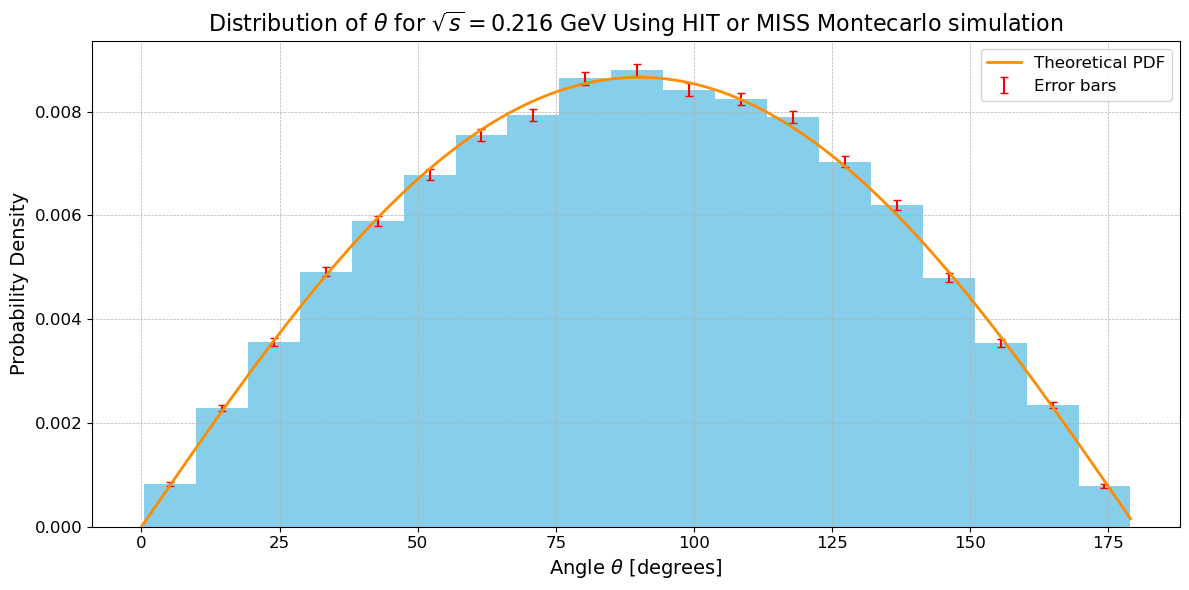

In [8]:
#Plot
#num_bins_hm = int(np.sqrt(len(theta_samples_hm)))

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(theta_samples_hm, bins="doane", density=True, color='skyblue')

bin_centers = 0.5 * (bins[1:] + bins[:-1]) #For every plot
bin_width = np.diff(bins) #For every plot
total_samples_hm = len(theta_samples_hm)
errors_hm = np.sqrt(counts / (total_samples_hm * bin_width))
plt.errorbar(bin_centers, counts, yerr=errors_hm, fmt='none', ecolor='r', capsize=3, label='Error bars')

plt.plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using HIT or MISS Montecarlo simulation', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### > METROPOLIS

In [9]:
def metropolis_hastings(distribution, initial_sample, interations, passes, s=E_exp**2):
    current_sample = initial_sample
    samples = [current_sample]
    accepted = 0
    for i in range(iterations):
        new_sample = np.random.normal(current_sample, passes) #proposal distribution
        acceptance_ratio = distribution(new_sample, s) / distribution(current_sample, s)
        if (np.random.uniform(0,1,1) <= acceptance_ratio):
            current_sample = new_sample
            accepted += 1
        samples.append(current_sample)
    return np.asarray(samples),accepted

initial_sample = 90
passes = 7.5

In [10]:
#Data saving and performance of the method
mem_before_mh = process.memory_info().rss / 1024 / 1024
start_time_mh = time.time()
theta_samples_mh, accepted = metropolis_hastings(pdf_theta_norm, initial_sample, iterations, passes)
end_time_mh = time.time()
mem_after_mh = process.memory_info().rss / 1024 / 1024
    
#filename_mh = f"data/theta_samples_MH.csv"
#np.savetxt(filename_mh, theta_samples_mh)

time_mh = round((end_time_mh - start_time_mh),3)
mem_usage_mh = round((mem_after_mh - mem_before_mh),3)
accepted_mh = round((len(theta_samples_mh)/iterations),3)

print(f"Execution time: {time_mh} seconds")
print(f"Memory usage: {mem_usage_mh} MB")
print(f"Accepted rate: {accepted_mh}")

Execution time: 1.746 seconds
Memory usage: 2.367 MB
Accepted rate: 1.0


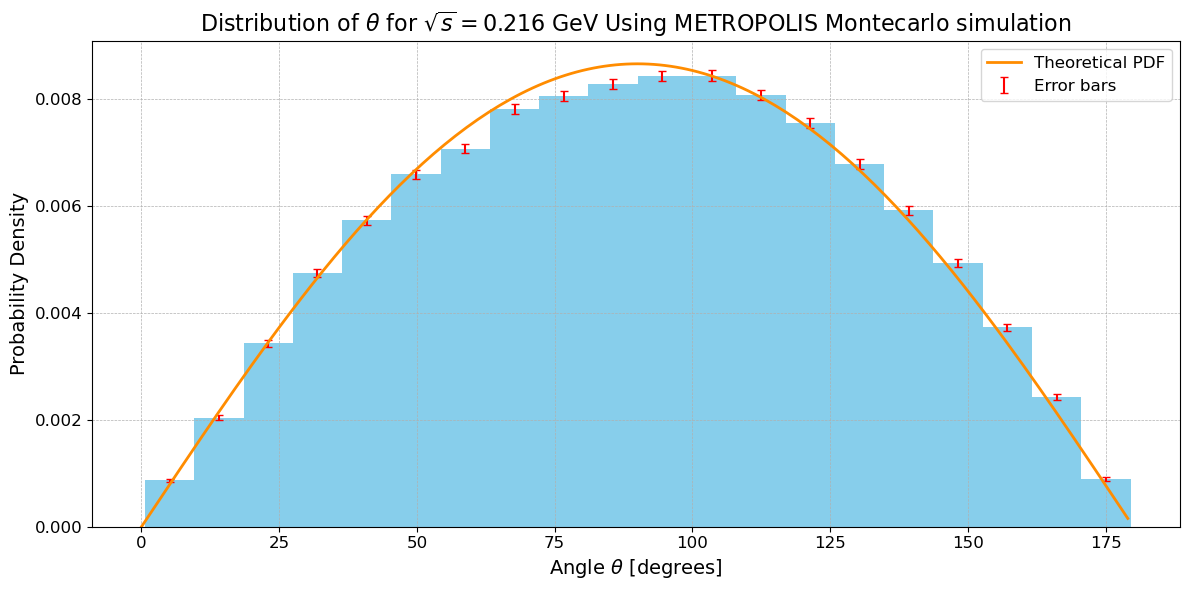

In [11]:
#Plot
#num_bins_mh = int(np.sqrt(len(theta_samples_mh)))

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(theta_samples_mh, bins="doane", density=True, color='skyblue')

bin_centers = 0.5 * (bins[1:] + bins[:-1]) #For every plot
bin_width = np.diff(bins) #For every plot
total_samples_mh = len(theta_samples_mh)
errors_mh = np.sqrt(counts / (total_samples_mh * bin_width))
plt.errorbar(bin_centers, counts, yerr=errors_mh, fmt='none', ecolor='r', capsize=3, label='Error bars')

plt.plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using METROPOLIS Montecarlo simulation', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

### > INVERSE SAMPLING

In [12]:
#Func
def pdf_cos(z, s=E_exp**2):#- comes from sin(theta)d(theta) = -d(cos(theta))= -dz
    return(((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*((1+(4*muon_mass**2/s))+(1-(4*muon_mass**2/s))*z**2))*0.389379e6

cost_norm_cos =integrate.quad(lambda z: pdf_cos(z),-1,1)

def pdf_cos_norm(z,s=E_exp**2):
    return pdf_cos(z,s)/cost_norm_z[0]

def cdf_zeros(y,x,s):
    cost = ((alpha**2)*np.pi*2/(4*s))*np.sqrt(1-(4*muon_mass**2/s))*conversion0
    norm_cost = total_cross_section_nb(s)
    return(- cost/(norm_cost))*( 1/3*(1-(4*muon_mass**2/s))*y**3 + \
                                (1+(4*muon_mass**2/s))*y - 4/3*(1 + 2*muon_mass**2/s) ) - x

In [13]:
#Data saving and performance of the method
mem_before_is = process.memory_info().rss / 1024 / 1024
start_time_is = time.time()
r_samples = np.random.uniform(0,1,iterations)
theta_samples_is = [brentq((cdf_zeros),-1,1,args=(r,s)) for r,s in zip(r_samples,[E_exp**2]*iterations)]
end_time_is = time.time()
mem_after_is = process.memory_info().rss / 1024 / 1024
    
#filename_is = f"data/theta_samples_IS.csv"
#np.savetxt(filename_is, theta_samples_is)

time_is = round((end_time_is - start_time_is),3)
mem_usage_is = round((mem_after_mh - mem_before_mh),3)
accepted_is = round((len(theta_samples_mh)/iterations),3)

print(f"Execution time: {time_is} seconds")
print(f"Memory usage: {mem_usage_is} MB")
print(f"Accepted rate: {accepted_is}")

Execution time: 7.908 seconds
Memory usage: 2.367 MB
Accepted rate: 1.0


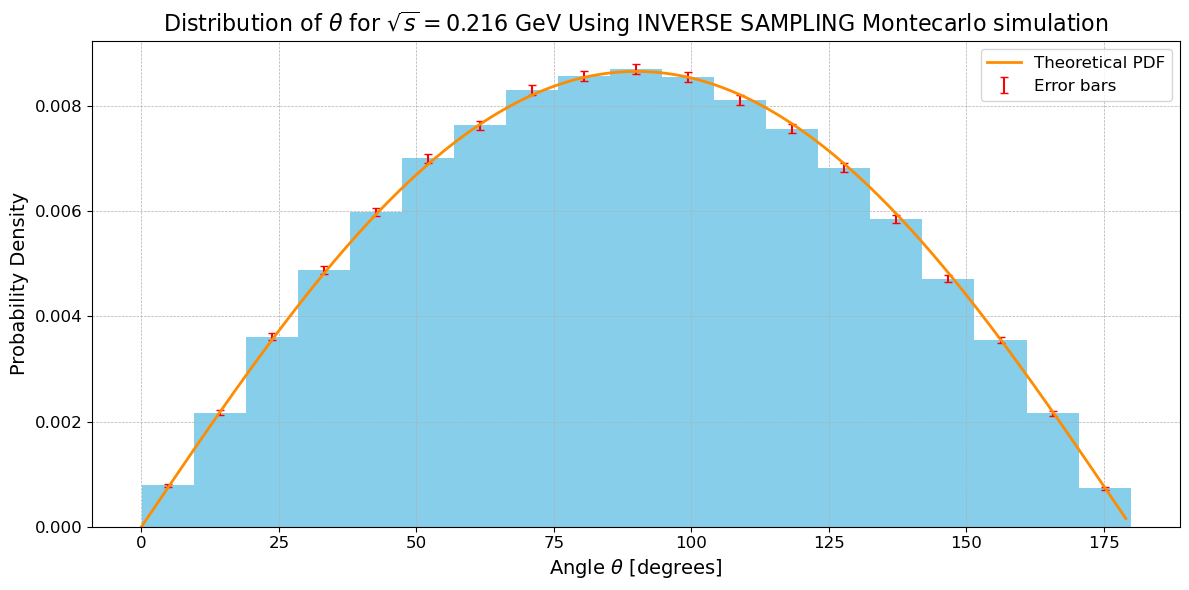

In [14]:
#Plot
theta_sample_is_converted = 180*np.arccos(theta_samples_is)/np.pi
#num_bins_is = int(np.sqrt(len(theta_samples_is)))

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(theta_sample_is_converted, bins="doane", density=True, color='skyblue')

bin_centers = 0.5 * (bins[1:] + bins[:-1]) #For every plot
bin_width = np.diff(bins) #For every plot
total_samples_is = len(theta_sample_is_converted)
errors_is = np.sqrt(counts / (total_samples_is * bin_width))
plt.errorbar(bin_centers, counts, yerr=errors_is, fmt='none', ecolor='r', capsize=3, label='Error bars')

plt.plot(angles, pdf_theta_norm(angles), color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using INVERSE SAMPLING Montecarlo simulation', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Comparison
methods = ["Hit or Miss", "Metropolis - Hastings", "Inverse sampling"]
times = [time_hm, time_mh, time_is]
mem_usages = [mem_usage_hm, mem_usage_mh, mem_usage_is]
acceptances = [accepted_hm, accepted_mh, accepted_is]

for method, time, mem_usage, acceptance in zip(methods, times, mem_usages, acceptances):
    print(f"{method}: Time = {time}, Memory usage = {mem_usage}, Acceptance = {acceptance}")

Hit or Miss: Time = 0.013, Memory usage = 2.098, Acceptance = 0.645
Metropolis - Hastings: Time = 1.746, Memory usage = 2.367, Acceptance = 1.0
Inverse sampling: Time = 7.908, Memory usage = 2.367, Acceptance = 1.0


In [16]:
# Comparison with babayaga

[BabaYaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) is a Monte Carlo event generator for $e^+e^- --> e^+e^-, μ^+μ^-, γγ$ and $π^+π^-$ processes at flavour factories, i.e. for energies below 10-12 GeV, it has been developed at the INFN center of Pavia by  C.M. Carloni Calame, G. Montagna, O. Nicrosini, F. Piccinini.

In [17]:
'''Babayaga = np.loadtxt("matched_el_th_exp_200.txt").T
j = 1.05 #da capire che fattore mettere (voglio scegliere il migliore possibile)

plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(theta_sample_is_converted, bins=num_bins_is, density=True, color='skyblue')
k=(np.max(Babayaga[1]))*j/np.max(counts)
Baba_plotted = Babayaga[1]/k
centers = [Babayaga[0][i]+(Babayaga[0][i+1]-Babayaga[0][i])/2 for i in np.arange(0,len(Babayaga[0])-1)]
centers.append(Babayaga[0][-1]+(Babayaga[0][-1]-Babayaga[0][-2]))
plt.plot(centers,Baba_plotted, color='darkorange', linewidth=2, label="Theoretical PDF")
plt.title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV Using Babayaga distribution with Inverse Sampling samples', fontsize=16)
plt.xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()'''

'Babayaga = np.loadtxt("matched_el_th_exp_200.txt").T\nj = 1.05 #da capire che fattore mettere (voglio scegliere il migliore possibile)\n\nplt.figure(figsize=(12, 6))\ncounts, bins, patches = plt.hist(theta_sample_is_converted, bins=num_bins_is, density=True, color=\'skyblue\')\nk=(np.max(Babayaga[1]))*j/np.max(counts)\nBaba_plotted = Babayaga[1]/k\ncenters = [Babayaga[0][i]+(Babayaga[0][i+1]-Babayaga[0][i])/2 for i in np.arange(0,len(Babayaga[0])-1)]\ncenters.append(Babayaga[0][-1]+(Babayaga[0][-1]-Babayaga[0][-2]))\nplt.plot(centers,Baba_plotted, color=\'darkorange\', linewidth=2, label="Theoretical PDF")\nplt.title(r\'Distribution of $\theta$ for $\\sqrt{s}=$\' + str(round(E_exp, 3)) + \' GeV Using Babayaga distribution with Inverse Sampling samples\', fontsize=16)\nplt.xlabel(r\'Angle $\theta$ [degrees]\', fontsize=14)\nplt.ylabel(\'Probability Density\', fontsize=14)\nplt.legend(fontsize=12)\nplt.grid(True, which=\'both\', linestyle=\'--\', linewidth=0.5)\nplt.tick_params(axis=\'b

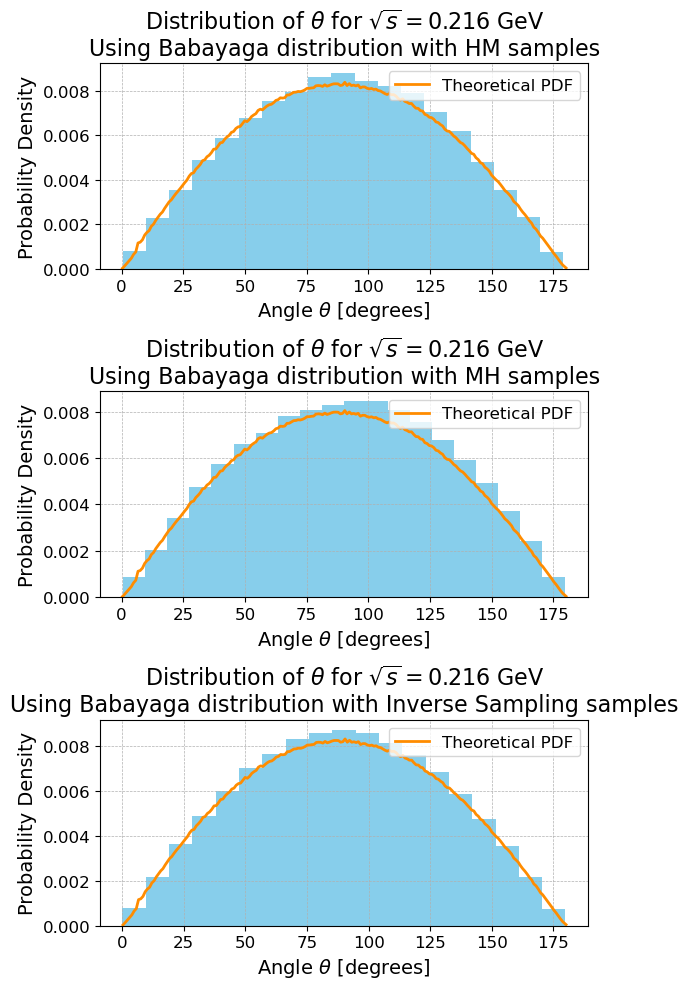

In [18]:
Babayaga = np.loadtxt("matched_el_th_exp_200.txt").T
j = 1.05 #da capire che fattore mettere (voglio scegliere il migliore possibile)

def plot_distribution(ax, theta_samples, sample_label, E_exp):
    counts, bins, patches = ax.hist(theta_samples, bins="doane", density=True, color='skyblue')
    k = (np.max(Babayaga[1])) * j / np.max(counts)
    Baba_plotted = Babayaga[1] / k
    centers = [Babayaga[0][i] + (Babayaga[0][i+1] - Babayaga[0][i]) / 2 for i in np.arange(0, len(Babayaga[0]) - 1)]
    centers.append(Babayaga[0][-1] + (Babayaga[0][-1] - Babayaga[0][-2]))
    ax.plot(centers, Baba_plotted, color='darkorange', linewidth=2, label="Theoretical PDF")
    ax.set_title(r'Distribution of $\theta$ for $\sqrt{s}=$' + str(round(E_exp, 3)) + ' GeV\nUsing Babayaga distribution with ' + sample_label, fontsize=16)
    ax.set_xlabel(r'Angle $\theta$ [degrees]', fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)

fig, axs = plt.subplots(3, 1, figsize=(6, 10), tight_layout=True)
plot_distribution(axs[0], theta_samples_hm, 'HM samples', E_exp)
plot_distribution(axs[1], theta_samples_mh, 'MH samples', E_exp)
plot_distribution(axs[2], theta_sample_is_converted, 'Inverse Sampling samples', E_exp)
plt.tight_layout()

plt.show()

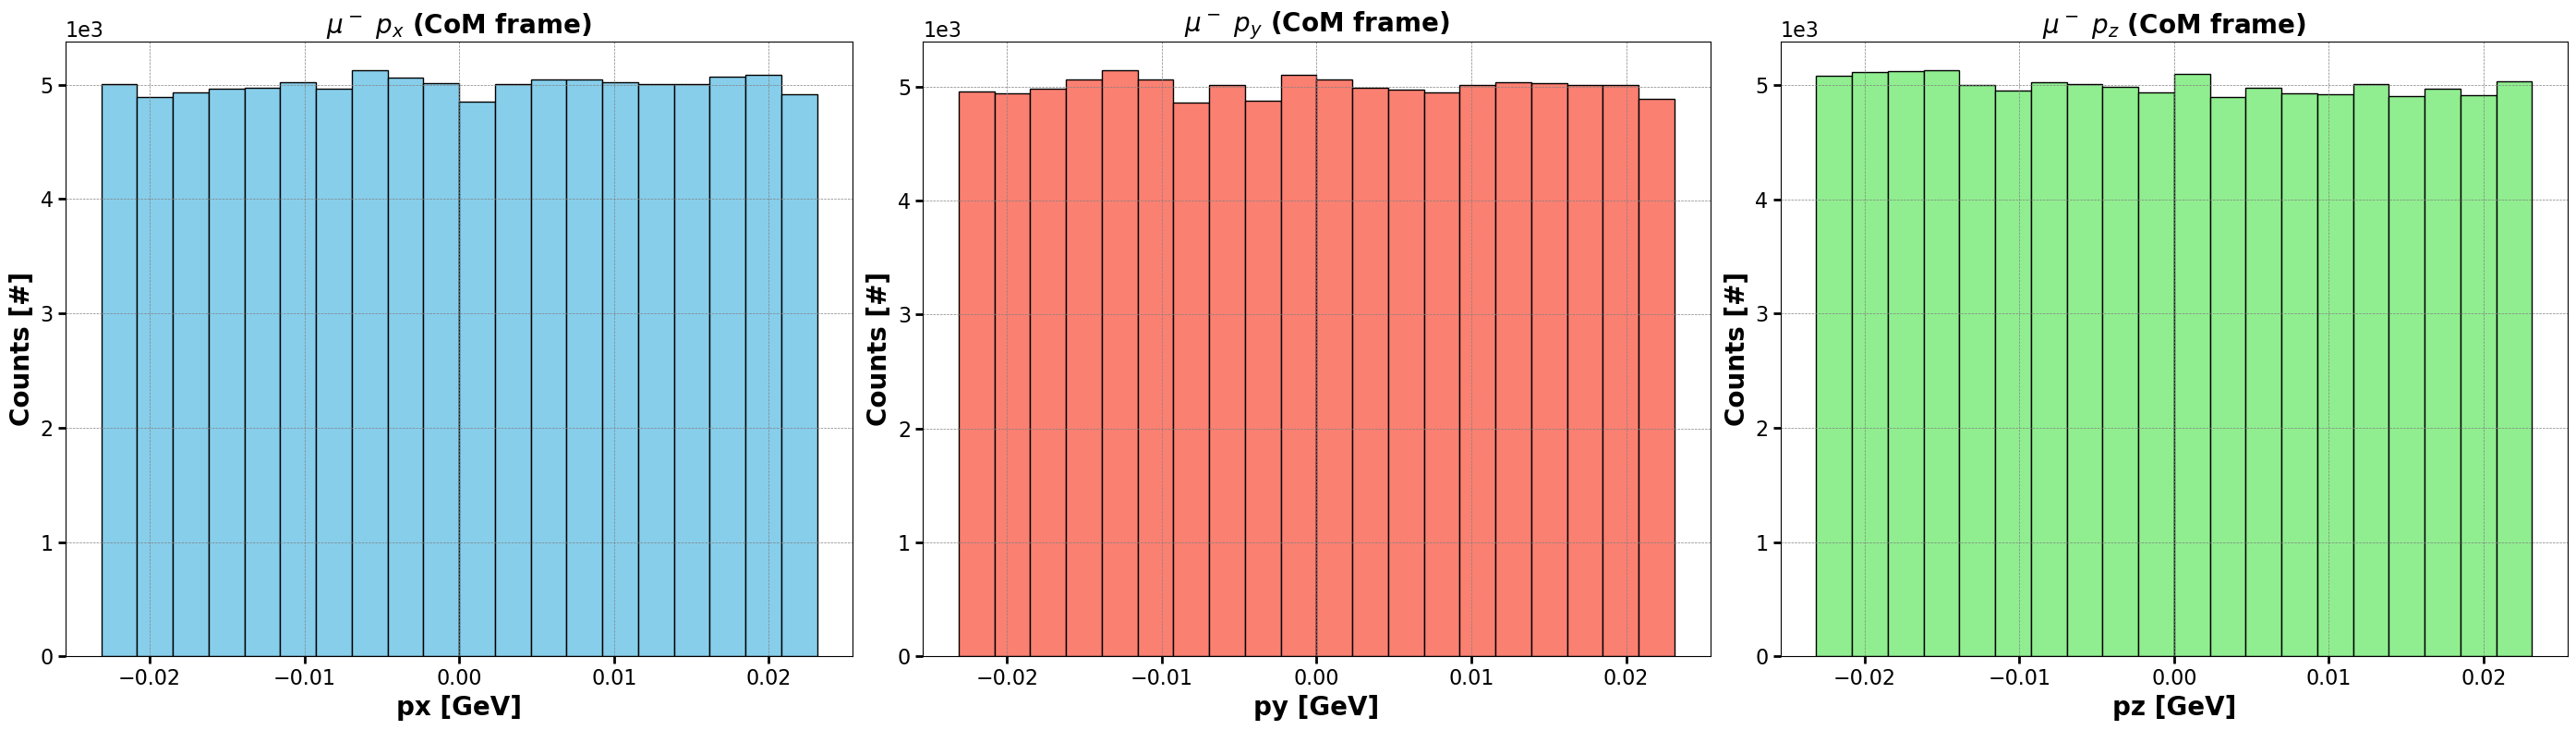

   Anti_muon_px  Anti_muon_py  Anti_muon_pz   Muon_px   Muon_py   Muon_pz
0     -0.021564     -0.001394      0.008222  0.021564  0.001394 -0.008222
1      0.018101      0.008002      0.011953 -0.018101 -0.008002 -0.011953
2     -0.018532      0.000069      0.013824  0.018532 -0.000069 -0.013824
3     -0.017876     -0.013634     -0.005395  0.017876  0.013634  0.005395
4      0.002596      0.007974     -0.021546 -0.002596 -0.007974  0.021546


In [19]:
%precision 6
theta = theta_sample_is_converted
N_samples = len(theta)
phi = 360*np.random.random(N_samples)
p_1 = np.sqrt(E_exp**2/4 - muon_mass**2)
momenta=pd.DataFrame(columns=['Anti_muon_px','Anti_muon_py','Anti_muon_pz','Muon_px','Muon_py','Muon_pz'])

sin_theta_c = np.sin(theta*(np.pi/180))
cos_theta_c = np.cos(theta*(np.pi/180))
sin_phi_c = np.sin(phi*(np.pi/180))
cos_phi_c = np.cos(phi*(np.pi/180))

momenta['Anti_muon_px'] = p_1*cos_phi_c*sin_theta_c
momenta['Anti_muon_py'] = p_1*sin_phi_c*sin_theta_c
momenta['Anti_muon_pz'] = p_1*cos_theta_c
momenta['Muon_px'] = - momenta['Anti_muon_px']
momenta['Muon_py'] = - momenta['Anti_muon_py']
momenta['Muon_pz'] = - momenta['Anti_muon_pz']

momenta.to_csv("data/Momenta_CoM.csv", index=False, index_label=False)
momenta = pd.read_csv("data/Momenta_CoM.csv")

fig, ax = plt.subplots(1, 3, figsize=(28, 8))
titles = [r'$\mu^-$ $p_x$ (CoM frame)', r'$\mu^-$ $p_y$ (CoM frame)', r'$\mu^-$ $p_z$ (CoM frame)']
colors = ['skyblue', 'salmon', 'lightgreen']

for i, coord in enumerate(['Muon_px', 'Muon_py', 'Muon_pz']):
    ax[i].hist(momenta[coord], bins=20, color=colors[i], edgecolor='black')
    ax[i].set_title(titles[i], fontsize=20, fontweight='bold')
    ax[i].set_ylabel(r"Counts [#]", fontsize=20, fontweight='bold')
    ax[i].set_xlabel(f'{coord[-2:]} [GeV]', fontsize=20, fontweight='bold')
    ax[i].tick_params(labelsize=16, length=6, width=2)
    ax[i].ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
    ax[i].yaxis.get_offset_text().set_fontsize(16)
    ax[i].grid(visible=True, which='major', color='grey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print(momenta.head())